In [48]:
import pandas as pd
import numpy as np
import ta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


# Load Stock Data

In [2]:
df = pd.read_csv('../data/TSLA_data.csv', parse_dates=['Date'], index_col='Date')

# Add Basic Features

In [3]:
df['Price Change'] = df['Adj Close'].pct_change()
df['Volume Change'] = df['Volume'].pct_change()

# Add Technical Indicators

In [4]:
# # Add moving averages - used for trend identification
# df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
# df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()

# # Add EMA - used for trend identification for more recent prices
# df['EMA_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()

# # Add RSI - momentum indicator used to identify overbought/oversold conditions
# df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()

# # Add MACD - momentum indicator used to identify trend reversals
# macd = ta.trend.MACD(df['Adj Close'])
# df['MACD'] = macd.macd()
# df['MACD_signal'] = macd.macd_signal()
# df['MACD_diff'] = macd.macd_diff()

# # Add Bollinger Bands - used to identify overbought/oversold conditions - price should be between bands
# bb = ta.volatility.BollingerBands(df['Adj Close'])
# df['BB_high'] = bb.bollinger_hband()
# df['BB_low'] = bb.bollinger_lband()

# # Add ADX - used to identify trend strength - 25 is considered a strong trend - pos > neg indicates uptrend and vice versa
# adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Adj Close'], fillna=False, window=14)
# df['ADX_pos'] = adx.adx_pos()
# df['ADX_neg'] = adx.adx_neg()
# df['ADX'] = adx.adx()

df = ta.add_all_ta_features(df, 'Open', 'High', 'Low', 'Adj Close', 'Volume', fillna=False)
df

c:\Users\lianz\AppData\Local\pypoetry\Cache\virtualenvs\trading_bot-m0vi2t_Z-py3.12\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   14.858000   14.883333   14.217333   14.620667   14.620667   
2015-01-05   14.303333   14.433333   13.810667   14.006000   14.006000   
2015-01-06   14.004000   14.280000   13.614000   14.085333   14.085333   
2015-01-07   14.223333   14.318667   13.985333   14.063333   14.063333   
2015-01-08   14.187333   14.253333   14.000667   14.041333   14.041333   
...                ...         ...         ...         ...         ...   
2022-12-23  126.370003  128.619995  121.019997  123.150002  123.150002   
2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
2022-12-28  110.349998  116.269997  108.239998  112.709999  112.709999   
2022-12-29  120.389999  123.570000  117.500000  121.820000  121.820000   
2022-12-30  119.949997  124.480003  119.750000  123.180000  123.180000   

               Volume  Price Change  Volume Change    volume_adi   volume_obv  \
Date                                                                            
2015-01-02   71466000           NaN            NaN  1.509465e+07     71466000   
2015-01-05   80527500     -0.042041       0.126795 -1.490936e+07     -9061500   
2015-01-06   93928500      0.005664       0.166415  2.410989e+07     84867000   
2015-01-07   44526000     -0.001562      -0.525959  4.217776e+05     40341000   
2015-01-08   51637500     -0.001564       0.159716 -3.459365e+07    -11296500   
...               ...           ...            ...           ...          ...   
2022-12-23  166989700     -0.017551      -0.205153  1.008668e+10  11301974100   
2022-12-27  208643400     -0.114089       0.249439  9.891045e+09  11093330700   
2022-12-28  221070500      0.033089       0.059561  9.916098e+09  11314401200   
2022-12-29  221923300      0.080827       0.003858  1.001006e+10  11536324500   
2022-12-30  157777300      0.011164      -0.289046  1.008111e+10  11694101800   

            ...  momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  \
Date        ...                                                         
2015-01-02  ...           NaN                  NaN                NaN   
2015-01-05  ...           NaN                  NaN                NaN   
2015-01-06  ...           NaN                  NaN                NaN   
2015-01-07  ...           NaN                  NaN                NaN   
2015-01-08  ...           NaN                  NaN                NaN   
...         ...           ...                  ...                ...   
2022-12-23  ...    -10.433928            -7.869638          -2.564290   
2022-12-27  ...    -11.838146            -8.663340          -3.174806   
2022-12-28  ...    -12.696081            -9.469888          -3.226193   
2022-12-29  ...    -12.765484           -10.129007          -2.636477   
2022-12-30  ...    -12.625903           -10.628387          -1.997517   

            momentum_pvo  momentum_pvo_signal  momentum_pvo_hist  \
Date                                                               
2015-01-02           NaN                  NaN                NaN   
2015-01-05           NaN                  NaN                NaN   
2015-01-06           NaN                  NaN                NaN   
2015-01-07           NaN                  NaN                NaN   
2015-01-08           NaN                  NaN                NaN   
...                  ...                  ...                ...   
2022-12-23     17.689086            13.348539           4.340547   
2022-12-27     19.438434            14.566518           4.871916   
2022-12-28     20.934566            15.840127           5.094438   
2022-12-29     21.670103            17.006123           4.663981   
2022-12-30     19.004365            17.405771           1.598594   

            momentum_kama  others_dr  others_dlr   others_cr  
Date                                                          
2015-01-02            NaN        NaN    

In [5]:
# # Create a subplot
# fig = make_subplots(rows=5, cols=1, shared_xaxes=True, 
#                     vertical_spacing=0.02, subplot_titles=("Closing Price", "Volume", "Moving Averages", "RSI", "MACD"))

# # Plot 1: Closing Price
# fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', name='Close Price'), row=1, col=1)

# # Plot 2: Volume
# fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume'), row=2, col=1)

# # Plot 3: Moving Averages
# fig.add_trace(go.Scatter(x=df.index, y=df['SMA_10'], mode='lines', name='10-day SMA'), row=3, col=1)
# fig.add_trace(go.Scatter(x=df.index, y=df['SMA_50'], mode='lines', name='50-day SMA'), row=3, col=1)
# fig.add_trace(go.Scatter(x=df.index, y=df['EMA_10'], mode='lines', name='10-day EMA', line=dict(dash='dot')), row=3, col=1)

# # Plot 4: RSI
# fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], mode='lines', name='RSI'), row=4, col=1)
# fig.add_hline(y=70, line_dash="dot", line_color="red", row=4, col=1)
# fig.add_hline(y=30, line_dash="dot", line_color="green", row=4, col=1)

# # Plot 5: MACD
# # MACD Line
# fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], mode='lines', name='MACD Line'), row=5, col=1)
# # Signal Line
# fig.add_trace(go.Scatter(x=df.index, y=df['MACD_signal'], mode='lines', name='Signal Line', line=dict(dash='dot')), row=5, col=1)
# # Histogram
# fig.add_trace(go.Bar(x=df.index, y=df['MACD_diff'], name='Histogram'), row=5, col=1)

# # Update layout
# fig.update_layout(height=1000, width=1000, title_text="Tesla Stock Data Analysis", showlegend=True)
# fig.update_xaxes(title_text="Date", row=5, col=1)
# fig.update_yaxes(title_text="Price", row=1, col=1)
# fig.update_yaxes(title_text="Volume", row=2, col=1)
# fig.update_yaxes(title_text="Price", row=3, col=1)
# fig.update_yaxes(title_text="RSI", row=4, col=1)
# fig.update_yaxes(title_text="MACD", row=5, col=1)

# # Show plot
# fig.show()


# Assign Target Variable

If adjusted close price is higher than previous day adjusted close price, then the target variable is 1, otherwise, it is 0.

In [6]:
df['Target'] = (df['Adj Close'].shift(-1) > df['Adj Close']).astype(int)

# Cleaning Data

Dropping NaN values here makes most sense since technical indicators are the core features which are mostly based on moving averages with various window sizes. The NaN values are generated because there are not enough historical data for calculating moving averages in the early days.

In [7]:
# df.dropna(inplace=True)
df.drop(axis=1, labels=['trend_psar_up','trend_psar_down'],inplace=True)
df.dropna(inplace=True)

df.to_csv('../data/TSLA_data_with_indicators.csv')

# Feature Selection

In [114]:
df = pd.read_csv('../data/TSLA_data_with_indicators.csv', parse_dates=['Date'], index_col='Date')

# Show Pairplot to examine bivariate relationships

to make sure no two features are highly correlated.

In [81]:
# Plotting feature distributions
features = [i for i in df.columns]

# plotly
n_features = len(features)
n_rows = math.ceil(n_features / 5)
fig = make_subplots(rows=n_rows, cols=5, subplot_titles=features)
for i, feature in enumerate(features):
    fig.add_trace(
        go.Histogram(x=df[feature], nbinsx=40, name=feature),
        row=(i // 5) + 1,  # Integer division to determine row
        col=(i % 5) + 1    # Modulo operation to alternate columns
    )

fig.update_layout(height=300*n_rows, width=1400, title_text="Feature Distributions", showlegend=False)
fig.update_layout(bargap=0.1)
fig.show()

# # matplotlib
# for feature in features:
#     plt.figure(figsize=(10, 4))
#     sns.histplot(df[feature], bins=30, kde=True)
#     plt.title(f'Distribution of {feature}')
#     plt.show()

# sns.pairplot(df[features], corner=True, diag_kind='kde')
# plt.show()

# Judge Basic Importance with Random Forecast - Feature Importance

features: ['Adj Close', 'Volume', 'Price Change', 'Volume Change', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx', 'tre

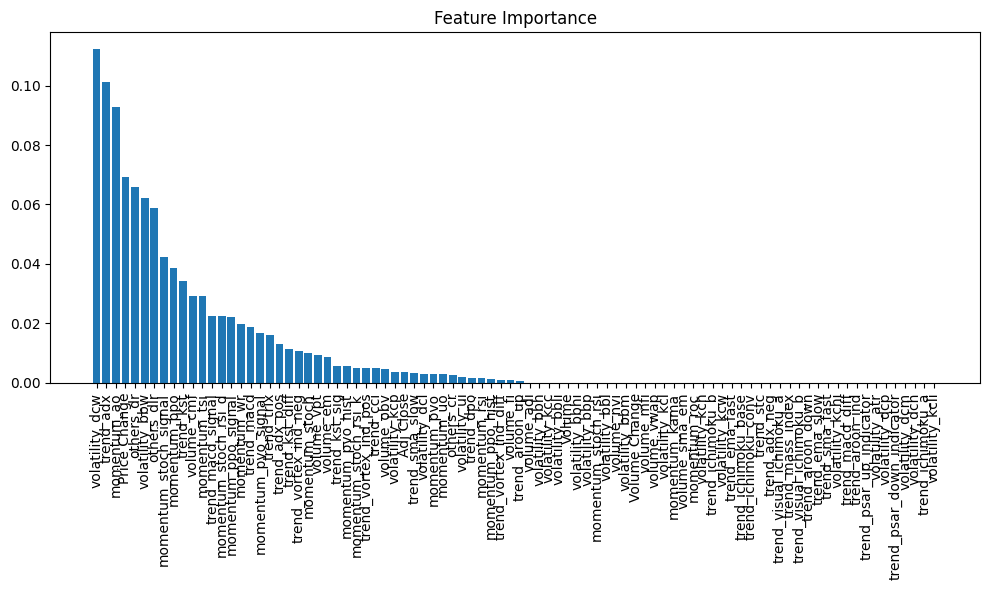

Accuracy with 88 features: 0.4807
Top 88 features remaining
Score: 0.480719794344473
features: ['Adj Close', 'Volume', 'Price Change', 'Volume Change', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv', 'trend_i

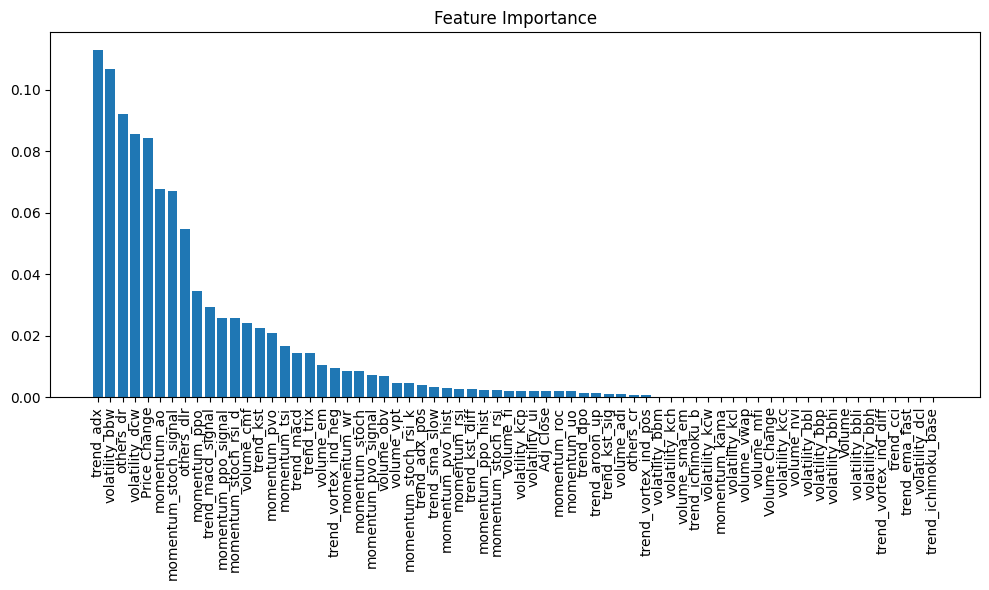

Accuracy with 68 features: 0.4602
Top 68 features remaining
Score: 0.4601542416452442
features: ['volatility_dcw', 'trend_adx', 'momentum_ao', 'Price Change', 'others_dr', 'volatility_bbw', 'others_dlr', 'momentum_stoch_signal', 'momentum_ppo', 'trend_kst', 'volume_cmf', 'momentum_tsi', 'trend_macd_signal', 'momentum_stoch_rsi_d', 'momentum_ppo_signal', 'momentum_wr', 'trend_macd', 'momentum_pvo_signal', 'trend_trix', 'trend_adx_pos', 'trend_kst_diff', 'trend_vortex_ind_neg', 'momentum_stoch', 'volume_vpt', 'volume_em', 'trend_kst_sig', 'momentum_pvo_hist', 'momentum_stoch_rsi_k', 'trend_vortex_ind_pos', 'trend_cci', 'volume_obv', 'volatility_kcp', 'Adj Close', 'trend_sma_slow', 'volatility_dcl', 'momentum_pvo', 'momentum_uo', 'others_cr', 'volatility_ui', 'trend_dpo', 'momentum_rsi', 'momentum_ppo_hist', 'trend_vortex_ind_diff', 'volume_fi', 'trend_aroon_up', 'volume_adi', 'volatility_bbh', 'volatility_kcc', 'volatility_bbli', 'Volume', 'volatility_bbhi', 'volatility_bbp', 'momentum_s

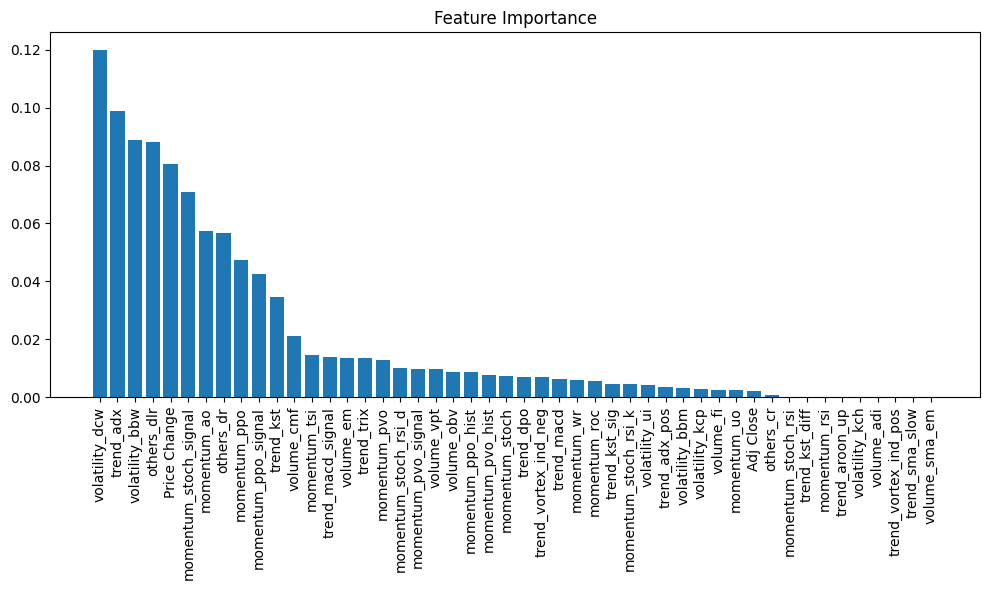

Accuracy with 48 features: 0.4550
Top 48 features remaining
Score: 0.455012853470437
features: ['trend_adx', 'volatility_bbw', 'others_dr', 'volatility_dcw', 'Price Change', 'momentum_ao', 'momentum_stoch_signal', 'others_dlr', 'momentum_ppo', 'trend_macd_signal', 'momentum_ppo_signal', 'momentum_stoch_rsi_d', 'volume_cmf', 'trend_kst', 'momentum_pvo', 'momentum_tsi', 'trend_macd', 'trend_trix', 'volume_em', 'trend_vortex_ind_neg', 'momentum_wr', 'momentum_stoch', 'momentum_pvo_signal', 'volume_obv', 'volume_vpt', 'momentum_stoch_rsi_k', 'trend_adx_pos', 'trend_sma_slow', 'momentum_pvo_hist', 'momentum_rsi', 'trend_kst_diff', 'momentum_ppo_hist', 'momentum_stoch_rsi', 'volume_fi', 'volatility_kcp', 'volatility_ui', 'Adj Close', 'momentum_roc', 'momentum_uo', 'trend_dpo', 'trend_aroon_up', 'trend_kst_sig', 'volume_adi', 'others_cr', 'trend_vortex_ind_pos', 'volatility_bbm', 'volatility_kch', 'volume_sma_em']
importances: [0.0988996  0.08887221 0.05664238 0.12       0.0804349  0.0574881


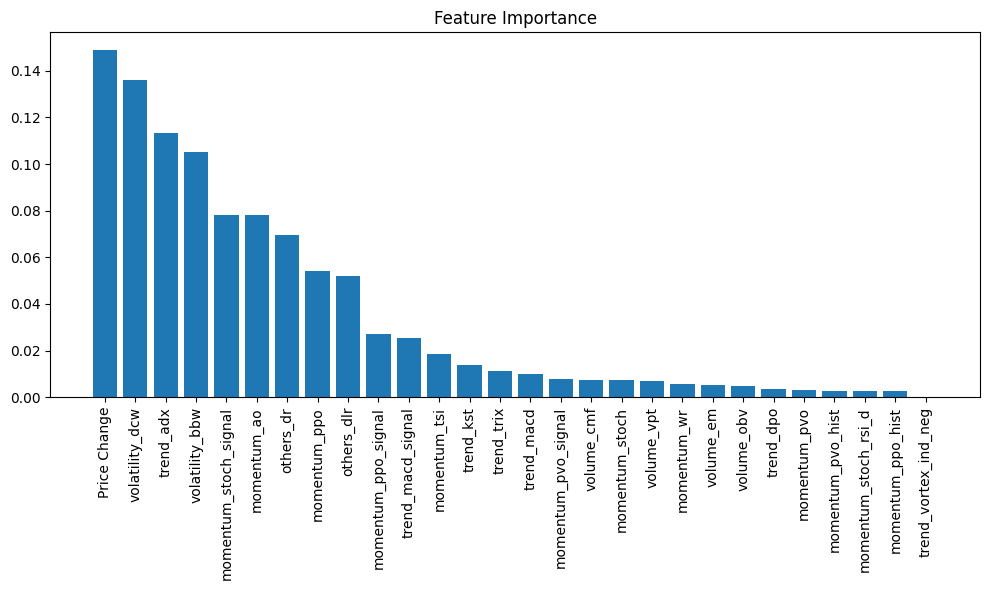

Accuracy with 28 features: 0.4576
Top 28 features remaining
Score: 0.45758354755784064
features: ['volatility_dcw', 'trend_adx', 'volatility_bbw', 'others_dlr', 'Price Change', 'momentum_stoch_signal', 'momentum_ao', 'others_dr', 'momentum_ppo', 'momentum_ppo_signal', 'trend_kst', 'volume_cmf', 'momentum_tsi', 'trend_macd_signal', 'volume_em', 'trend_trix', 'momentum_pvo', 'momentum_stoch_rsi_d', 'momentum_pvo_signal', 'volume_vpt', 'volume_obv', 'momentum_ppo_hist', 'momentum_pvo_hist', 'momentum_stoch', 'trend_dpo', 'trend_vortex_ind_neg', 'trend_macd', 'momentum_wr']
importances: [0.13603582 0.11351879 0.105      0.05183246 0.14903436 0.07803396
 0.07800618 0.0697086  0.05415665 0.02693541 0.01379613 0.00735518
 0.01868577 0.02523442 0.00512918 0.0110797  0.00294511 0.00268996
 0.00763828 0.00678496 0.00476292 0.00265352 0.00281064 0.00732187
 0.0035343  0.         0.00982444 0.0054914 ]
features: ['Price Change', 'volatility_dcw', 'trend_adx', 'volatility_bbw', 'momentum_stoch_sign

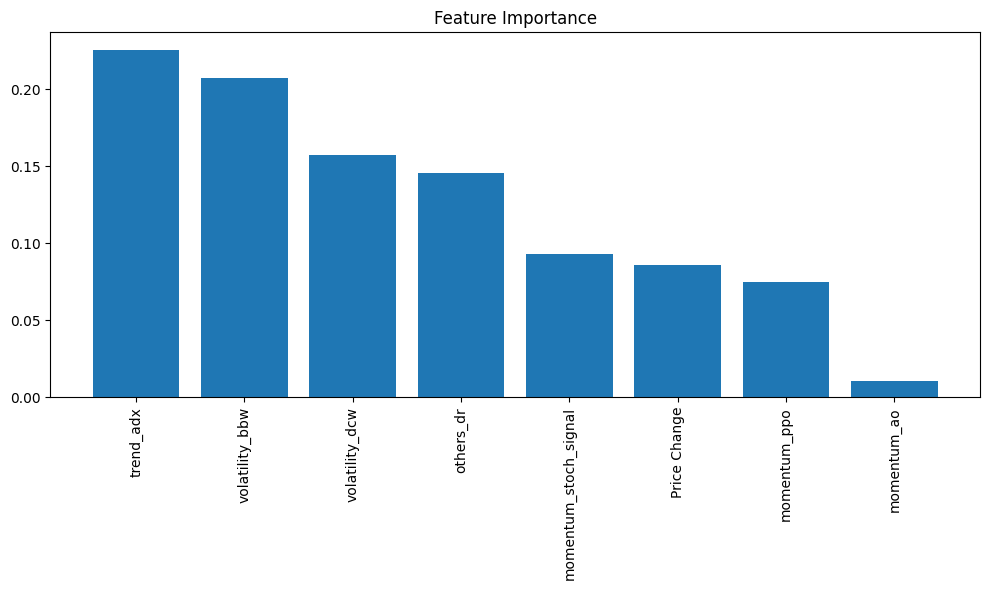

Accuracy with 8 features: 0.4653
Top 8 features remaining
Score: 0.4652956298200514
features: ['Price Change', 'volatility_dcw', 'trend_adx', 'volatility_bbw', 'momentum_stoch_signal', 'momentum_ao', 'others_dr', 'momentum_ppo']
importances: [0.08614976 0.15707165 0.22571525 0.20727323 0.09327167 0.01042
 0.14555371 0.07454472]
features: []
Top 0 features remaining


In [70]:
features = [i for i in df.columns if i not in ['Target']+['Open','High','Low','Close']]

# test_list = np.arange(1, len(features) + 1)

scores = []
number_of_features = []

for i in range(1, len(features) + 1):
    if i > 1 and len(features) > 5:
        # Select Top n_features-1 features
        features = [n for n in X.columns[sorted_indices][:-20]]
    print(f'features: {features}')

    if len(features) <= 5:
        print(f'Top {len(features)} features remaining')
        break

    # Prepare the data
    X = df[features]
    y = df['Target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    tscv = TimeSeriesSplit(n_splits=5)

    # # Use for splitting training and test data - time-series way (not random)
    # for train_index, test_index in tscv.split(X):
    #     print("TRAIN:", len(train_index), "TEST:", len(test_index))
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Hyperparameter grid
    param_dist = {
        'bootstrap': [False, True],
        'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'class_weight': [None, 'balanced', 'balanced_subsample'],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, None],
        'max_features': ['sqrt', 'log2'],
        'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40],
        'max_samples': [None],
        'min_impurity_decrease': [0.0],
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'n_estimators': [10, 50, 100, 200, 300, 400, 500],
        'n_jobs': [-1],
        'oob_score': [False],
        'random_state': [None],
        'verbose': [0],
        'warm_start': [False]
    }
    
    # Randomized Search
    rf = RandomForestClassifier()
    randomized_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, random_state=42)
    randomized_search.fit(X_train, y_train)

    # Best model
    best_model = randomized_search.best_estimator_

    # Feature Importance
    importances = best_model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Performance
    accuracy = best_model.score(X_test, y_test)
    print(f"Accuracy with {len(features)} features: {accuracy:.4f}")
    scores.append(accuracy)
    number_of_features.append(len(features))
    print(f'Top {len(features)} features remaining')
    print(f'Score: {best_model.score(X_test, y_test)}')
    print(f'features: {X.columns[sorted_indices]}')
    print(f'importances: {importances[sorted_indices]}')
 

# Plot scores with number of features

In [ ]:
# plot scores against number of features with plotly
scores = np.array(scores)*100
average_score = np.mean(scores)
fig = go.Figure()
fig.add_trace(go.Scatter(x=number_of_features, y=scores, mode='lines+markers'))
fig.update_layout(height=500, width=1000, title_text="Accuracy vs Number of Features", showlegend=False)
fig.update_xaxes(title_text="Number of Features")
fig.update_yaxes(title_text="Accuracy")

# calculate trend line
z = np.polyfit(number_of_features, scores, 1)
p = np.poly1d(z)

# add trend line to the plot
fig.add_trace(go.Scatter(x=number_of_features, y=p(number_of_features), mode='lines', name='Trendline'))

# update layout to show legend
fig.update_layout(showlegend=True)

# Assess Random Forest Selected Features

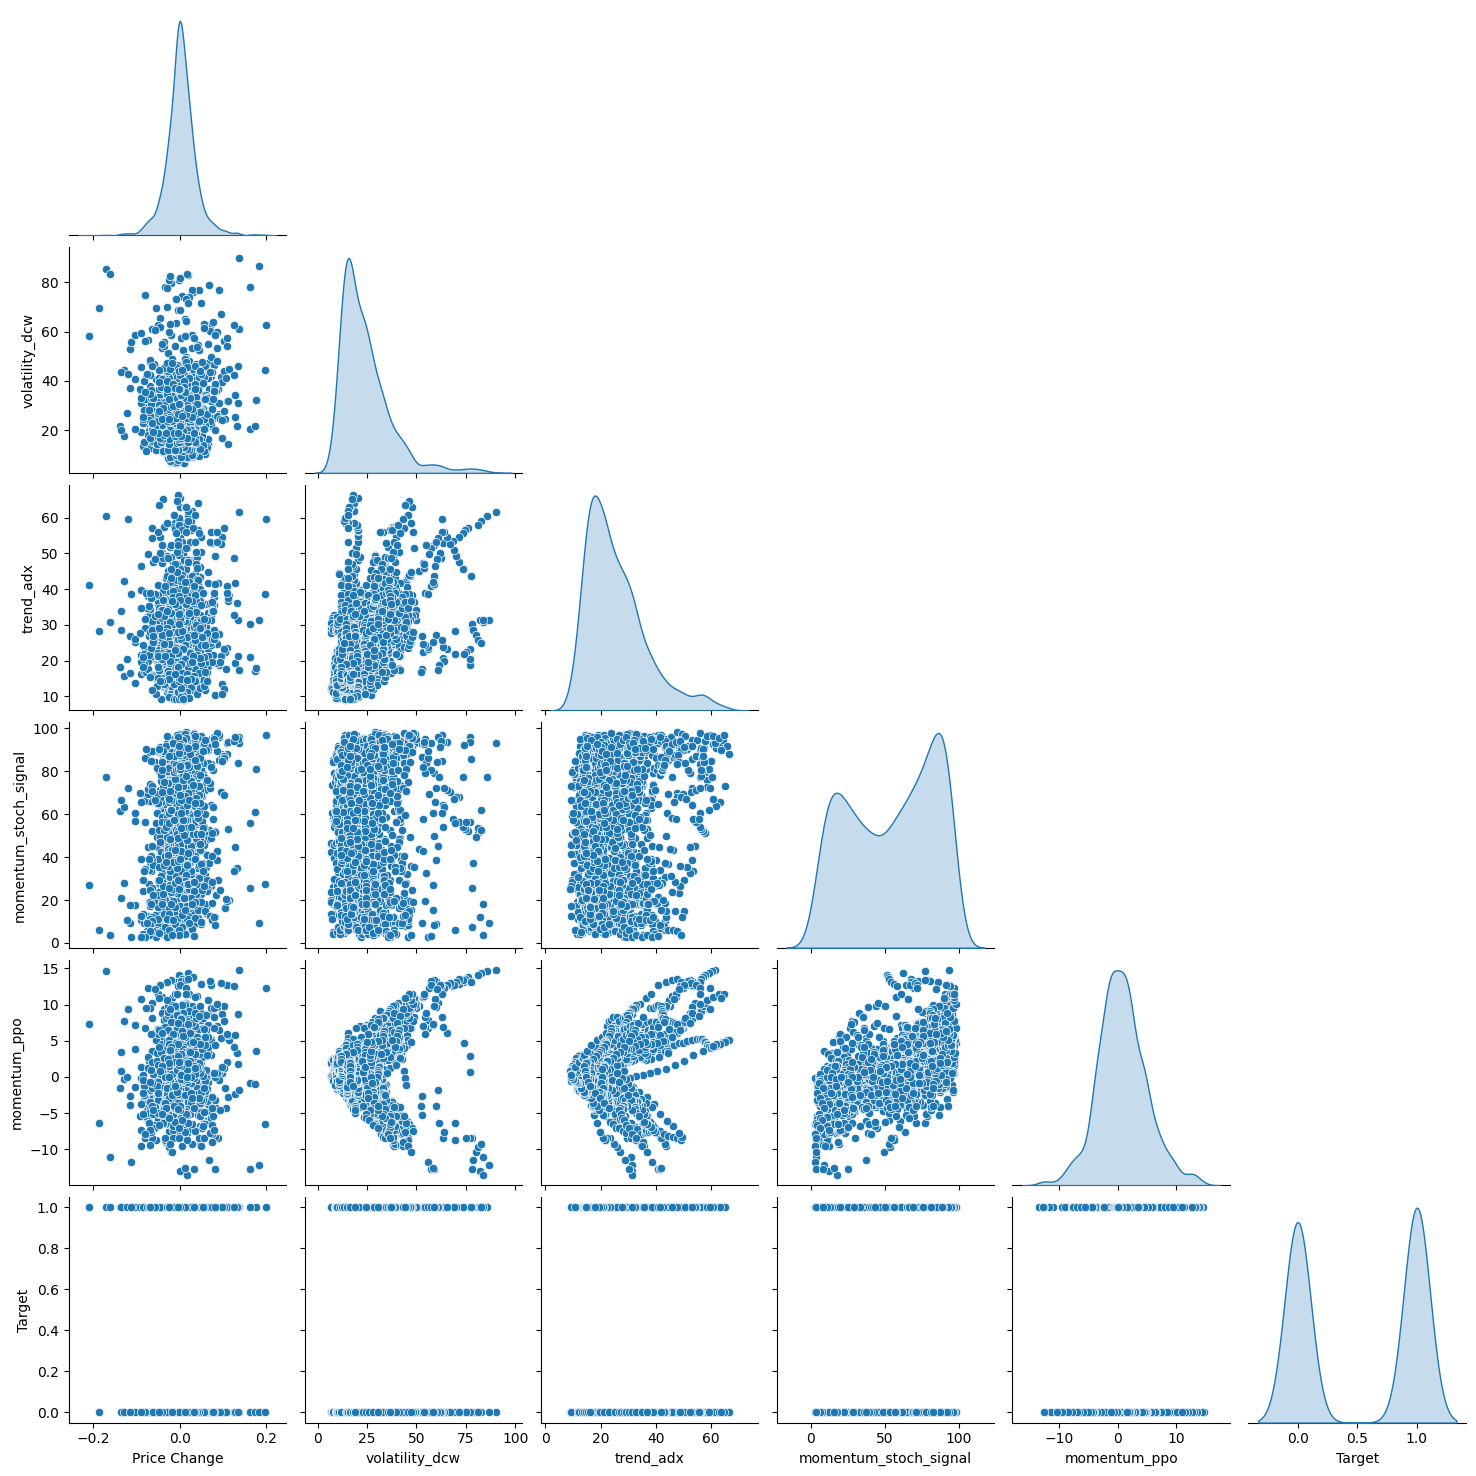

In [83]:
features_from_random_forest = ['Price Change', 'volatility_dcw', 'trend_adx', 'momentum_stoch_signal', 'momentum_ppo', 'Target']

# plotly
n_features = len(features_from_random_forest)
n_rows = math.ceil(n_features / 5)
fig = make_subplots(rows=n_rows, cols=5, subplot_titles=features_from_random_forest)
for i, feature in enumerate(features_from_random_forest):
    fig.add_trace(
        go.Histogram(x=df[feature], nbinsx=40, name=feature),
        row=(i // 5) + 1,  # Integer division to determine row
        col=(i % 5) + 1    # Modulo operation to alternate columns
    )

fig.update_layout(height=300*n_rows, width=1400, title_text="Feature Distributions", showlegend=False)
fig.update_layout(bargap=0.1)
fig.show()

sns.pairplot(df[features_from_random_forest], corner=True, diag_kind='kde')
plt.show()

# Retrain with hyperparameter tuning with selected features

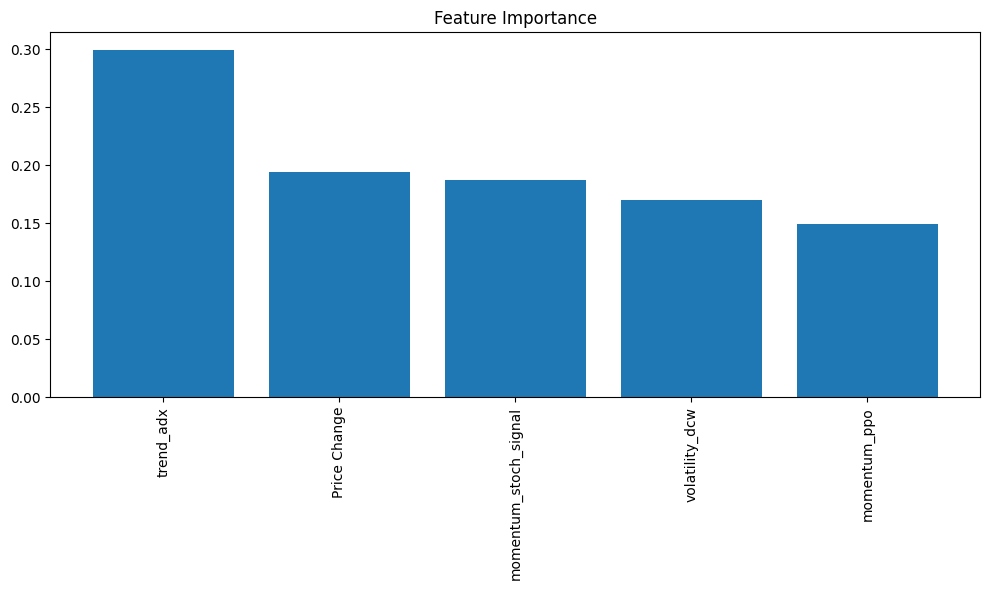

Accuracy with 0 features: 0.4756
Top 0 features remaining
Score: 0.4755784061696658
features: Index(['trend_adx', 'Price Change', 'momentum_stoch_signal', 'volatility_dcw',
       'momentum_ppo'],
      dtype='object')
importances: [0.29950047 0.19387915 0.18679045 0.17031037 0.14951955]


In [80]:
# Prepare the data
X = df[features_from_random_forest]
y = df['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
tscv = TimeSeriesSplit(n_splits=5)

# # Use for splitting training and test data - time-series way (not random)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", len(train_index), "TEST:", len(test_index))
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Hyperparameter grid
param_dist = {
    'bootstrap': [False, True],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, None],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40],
    'max_samples': [None],
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'n_jobs': [-1],
    'oob_score': [False],
    'random_state': [None],
    'verbose': [0],
    'warm_start': [False]
}

# Randomized Search
rf = RandomForestClassifier()
randomized_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, random_state=42)
randomized_search.fit(X_train, y_train)

# Best model
best_model = randomized_search.best_estimator_

# Feature Importance
importances = best_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Performance
accuracy = best_model.score(X_test, y_test)
print(f"Accuracy with {len(features)} features: {accuracy:.4f}")
print(f'Top {len(features)} features remaining')
print(f'Score: {best_model.score(X_test, y_test)}')
print(f'features: {X.columns[sorted_indices]}')
print(f'importances: {importances[sorted_indices]}')

Accuracy: 0.4755784061696658
Precision: 0.49767441860465117
Recall: 0.5270935960591133
F1 Score: 0.5119617224880382
ROC AUC: 0.47322421738439535
Confusion Matrix:
 [[ 78 108]
 [ 96 107]]
Log Loss: 18.90207015778894


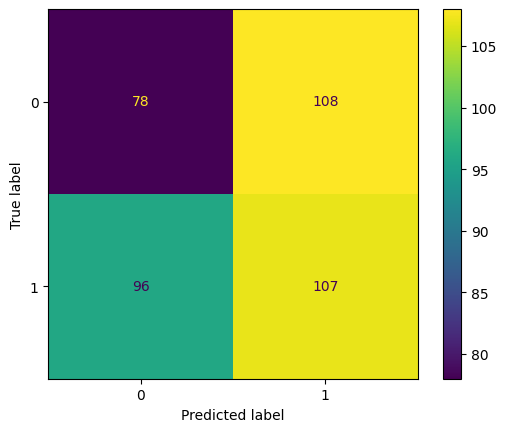

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
predictions = best_model.predict(X_test)

# Assuming y_test are your true labels and predictions are your model's predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
logloss = log_loss(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix) # need to minimize false negatives (where we predict a decrease in price but it actually increases)
disp.plot()
print("Log Loss:", logloss)


# Evaluation of trading strategy based on target variable

In [118]:
df[['Open','High','Low','Adj Close','Volume'] + features_from_random_forest]

Open        High         Low   Adj Close     Volume  \
Date                                                                    
2015-04-16   13.846667   13.944667   13.752667   13.780000   24886500   
2015-04-17   13.666000   13.792000   13.566667   13.786000   37048500   
2015-04-20   13.785333   13.856667   13.590000   13.684667   38389500   
2015-04-21   13.720000   14.050000   13.620667   13.960667   51487500   
2015-04-22   14.166667   14.792000   14.112667   14.629333  117945000   
...                ...         ...         ...         ...        ...   
2022-12-23  126.370003  128.619995  121.019997  123.150002  166989700   
2022-12-27  117.500000  119.669998  108.760002  109.099998  208643400   
2022-12-28  110.349998  116.269997  108.239998  112.709999  221070500   
2022-12-29  120.389999  123.570000  117.500000  121.820000  221923300   
2022-12-30  119.949997  124.480003  119.750000  123.180000  157777300   

            Price Change  volatility_dcw  trend_adx  momentum_stoch_signal  \
Date                                                                         
2015-04-16     -0.005437       15.841583  18.053831              82.056964   
2015-04-17      0.000435       15.797472  17.459797              81.266236   
2015-04-20     -0.007350       15.769131  17.072688              77.158910   
2015-04-21      0.020169       15.730745  17.190158              79.364164   
2015-04-22      0.047896       20.062795  18.685790              83.447529   
...                  ...             ...        ...                    ...   
2022-12-23     -0.017551       47.154679  36.640750               3.553951   
2022-12-27     -0.114089       55.823166  38.756666               2.779872   
2022-12-28      0.033089       57.354653  40.738163               3.293800   
2022-12-29      0.080827       58.707756  41.449224               8.255856   
2022-12-30      0.011164       58.329579  41.974055              15.305985   

            momentum_ppo  Target  
Date                              
2015-04-16      1.354261       1  
2015-04-17      1.351465       0  
2015-04-20      1.274305       1  
2015-04-21      1.360377       1  
2015-04-22      1.798669       0  
...                  ...     ...  
2022-12-23    -10.433928       0  
2022-12-27    -11.838146       1  
2022-12-28    -12.696081       1  
2022-12-29    -12.765484       1  
2022-12-30    -12.625903       0  

[1943 rows x 11 columns]

In [156]:
featured_df = df[['Open','High','Low','Adj Close','Volume'] + features_from_random_forest]

transaction_cost = 0.01 # 1% transaction cost
amount_invested = 10 # €10

def profit_intraday(x):
    if x['Target'] == 1:
        return (x['Next Day Close'] * (1 - transaction_cost)) - (x['Next Day Open'] * (1 - transaction_cost))
    else:
        return 0
    
def dollar_cost_averaging_timed(x):
    if x['Target'] == 1:
        return (amount_invested / (x['Open'] * (1 - transaction_cost)) ) # bought but never sold
    else:
        return 0

df['Next Day Open'] = df['Open'].shift(-1)
df['Next Day Close'] = df['Adj Close'].shift(-1)
df['Intraday Trade'] = df.apply(lambda x: profit_intraday(x), axis=1) # buying at open price of next day and selling at the next -1 target variable 
df['Timed DCA Shares'] = df.apply(lambda x: dollar_cost_averaging_timed(x), axis=1)
df['Timed DCA Shares Cumulative'] = df['Timed DCA Shares'].cumsum()

# Calculate cumulative profit
df['Profit Intraday'] = df['Intraday Trade'].cumsum()
df['Profit Timed DCA'] = (df['Timed DCA Shares'].cumsum() * df['Adj Close'].iloc[-1]) - (df['Target'].cumsum() * amount_invested)
# Plot the profit curve

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Profit Intraday'], mode='lines', name='Intraday Profit'))
fig.add_trace(go.Scatter(x=df.index, y=df['Profit Timed DCA'], mode='lines', name='Timed DCA Profit'))
fig.add_trace(go.Scatter(x=df.index, y=df['Target'].cumsum(), mode='lines', name='Cumulative Transactions'))
# Update plot layout
fig.update_layout(
    title='Profit Curve',
    xaxis_title='Time',
    yaxis_title='Cumulative Profit',
    hovermode='x'
)

fig.show()
df[['Target','Open','Adj Close','Next Day Open','Next Day Close','Intraday Trade','Timed DCA Shares','Timed DCA Shares Cumulative','Profit Intraday','Profit Timed DCA']]

Target        Open   Adj Close  Next Day Open  Next Day Close  \
Date                                                                        
2015-04-16       1   13.846667   13.780000      13.666000       13.786000   
2015-04-17       0   13.666000   13.786000      13.785333       13.684667   
2015-04-20       1   13.785333   13.684667      13.720000       13.960667   
2015-04-21       1   13.720000   13.960667      14.166667       14.629333   
2015-04-22       0   14.166667   14.629333      14.551333       14.573333   
...            ...         ...         ...            ...             ...   
2022-12-23       0  126.370003  123.150002     117.500000      109.099998   
2022-12-27       1  117.500000  109.099998     110.349998      112.709999   
2022-12-28       1  110.349998  112.709999     120.389999      121.820000   
2022-12-29       1  120.389999  121.820000     119.949997      123.180000   
2022-12-30       0  119.949997  123.180000            NaN             NaN   

            Intraday Trade  Timed DCA Shares  Timed DCA Shares Cumulative  \
Date                                                                        
2015-04-16        0.118800          0.729490                     0.729490   
2015-04-17        0.000000          0.000000                     0.729490   
2015-04-20        0.238260          0.732736                     1.462226   
2015-04-21        0.458039          0.736225                     2.198452   
2015-04-22        0.000000          0.000000                     2.198452   
...                    ...               ...                          ...   
2022-12-23        0.000000          0.000000                   382.946617   
2022-12-27        2.336401          0.085966                   383.032583   
2022-12-28        1.415700          0.091536                   383.124119   
2022-12-29        3.197703          0.083902                   383.208022   
2022-12-30        0.000000          0.000000                   383.208022   

            Profit Intraday  Profit Timed DCA  
Date                                           
2015-04-16         0.118800         79.858621  
2015-04-17         0.118800         79.858621  
2015-04-20         0.357060        160.117047  
2015-04-21         0.815099        240.805269  
2015-04-22         0.815099        240.805269  
...                     ...               ...  
2022-12-23      1730.404134      37151.364397  
2022-12-27      1732.740534      37151.953694  
2022-12-28      1734.156234      37153.229113  
2022-12-29      1737.353938      37153.564211  
2022-12-30      1737.353938      37153.564211  

[1943 rows x 10 columns]